# SSBU VOD helper

Insert your URL and click _Run after_ (Ctrl + F10 OR Runtime -> Run after) to get your output.

Note: please use either Youtube OR Twitch at once.


## Dependencies

Imports dependencies.


In [191]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os.path
from pathlib import Path
from tensorflow.keras.models import load_model
import subprocess

try:
    import ffmpeg
except ModuleNotFoundError:
    subprocess.run(["pip", "-q", "install", "ffmpeg-python"])
    import ffmpeg

In [192]:
# loads model from directory
model = load_model("./model")

### Download from YouTube


In [193]:
# @markdown Insert your Youtube URL to begin. { run: "auto" }
try:
    import pytube
except ModuleNotFoundError:
    subprocess.run(["pip", "-q", "install", "pytube"])
    import pytube

youtube_url = ""  # @param {type:"string"}

if youtube_url:
    yt = pytube.YouTube(youtube_url.replace("watch?v=", ""))
    yt = (
        yt.streams.filter(progressive=True, file_extension="mp4")
        .order_by("resolution")
        .desc()
        .first()
    )

    if not os.path.exists("."):
        os.makedirs(".")

    yt.download(".")

### Download from Twitch


In [3]:
#@markdown Insert your Twitch URL to begin. { run: "auto" }
twitch_url = "https://www.twitch.tv/videos/1926971349" #@param {type:"string"}

if twitch_url:
  !pip -q install twitch-dl
  !twitch-dl download $twitch_url -q 160p -f mp4
  # !twitch-dl download -q source -f mp4 $twitch_url

Looking up video...
Found: Smash Class 36 - feat NFL, Midoriss, Jix, Bosco & more by SmashBrosItalia
Output: 2023-09-16_1926971349_smashbrositalia_smash_class_36_feat_nfl_midoriss_jix_bosco_more.mp4
Fetching access token...
Fetching playlists...
Fetching playlist...

Downloaded 610/614 VODs 99% of ~210.4MB at 5.7MB/s ETA 00:00     

Joining files...
ffmpeg -i /tmp/twitch-dl/d6150caf00804038fd66_smashbrositalia_39965237541_1694871808/160p30/playlist_downloaded.m3u8 -c copy -metadata artist=SmashBrosItalia -metadata title=Smash Class 36 - feat NFL, Midoriss, Jix, Bosco & more -metadata encoded_by=twitch-dl -stats -loglevel warning file:2023-09-16_1926971349_smashbrositalia_smash_class_36_feat_nfl_midoriss_jix_bosco_more.mp4
frame=184096 fps=25225 q=-1.0 Lsize=  179715kB time=01:42:18.62 bitrate= 239.8kbits/s speed= 841x    

Deleting temporary files...

Downloaded: 2023-09-16_1926971349_smashbrositalia_smash_class_36_feat_nfl_midoriss_jix_bosco_more.mp4


## Directories handling

Creates snapshots folder and video-specific subfolders starting from the last added (downloaded) file.


In [194]:
# @title
import os
import glob
import shutil

# orders files by last added
files = list(filter(os.path.isfile, glob.glob("*")))
files.sort(key=lambda x: ".mp4" in x and os.path.getmtime(x))

# handles situation in which no file is present
if not files:
    raise Exception("An error has occurred: no video files in directory.")

# gets latest file added and sets directory name
input_file = files[-1]
dir_name = input_file.replace(".mp4", "")

# creates snapshots folder if it doesn't exist
for snapshots_dir in ["snapshots", f"snapshots/{dir_name}"]:
    try:
        os.mkdir(snapshots_dir)
    except FileExistsError:
        pass

## Video to frames conversion

Uses `ffmpeg-python` to convert a video file to a succession of frames from the same video, grabbing one frame each second and resizing it to 426x240. **This process will take a lot of time** depending on the length of the video, so sit tight.


In [7]:
# @title
print(f"Processing: {input_file}")
try:
    (
        ffmpeg.input(input_file)
        .filter("fps", fps=1)
        .output(
            f"snapshots/{dir_name}/%d.jpg",
            # s='426x240',
            start_number=0,
        )
        .run(capture_stdout=True, capture_stderr=True)
    )
except ffmpeg.Error as e:
    print("stdout:", e.stdout.decode("utf8"))
    print("stderr:", e.stderr.decode("utf8"))

Processing: 2023-09-16_1926971349_smashbrositalia_smash_class_36_feat_nfl_midoriss_jix_bosco_more.mp4


## Frames prediction

Defines `predict_screen` which handles each frame (resizing, normalization, etc.) and then predicts its label. This will also take a lot of time.


In [8]:
def predict_screen(img_dir, labels):
    img = tf.keras.preprocessing.image.load_img(
        img_dir, target_size=(224, 224)  # inputs directory  # resizes images
    )

    # (height, width, channels)
    img_tensor = tf.keras.preprocessing.image.img_to_array(img)

    # (1, height, width, channels), add a dimension because the model
    # expects this shape: (batch_size, height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)

    # normalization
    img_tensor /= 255.0

    # predicts the label of the test_images
    predictions = model.predict(img_tensor)

    # gets label with highest confidence
    prediction_index = np.argmax(predictions, axis=1)[0]
    label = labels[prediction_index]

    # uses original file's name as output name
    output_name = img_dir.split("/")[-1]

    return {output_name: label, "confidence": predictions[0][0]}

In [195]:
# labels definition
labels = {
    0: "gameplay",
    1: "junk",
}

# orders files by last added
files = list(filter(os.path.isfile, glob.glob("*")))
files.sort(key=lambda x: ".mp4" in x and os.path.getmtime(x))

# handles situation in which no file is present
if not files:
    raise Exception("An error has occurred: no video files in directory.")

# gets latest file added and sets directory name
input_file = files[-1]
dir_name = input_file.replace(".mp4", "")

# creates snapshots folder if it doesn't exist
for snapshots_dir in ["snapshots", f"snapshots/{dir_name}"]:
    try:
        os.mkdir(snapshots_dir)
    except FileExistsError:
        print("Snapshots folder already exists; skipping.")

snapshots_dir = rf"./snapshots/{dir_name}"
snapshots_dir

Snapshots folder already exists; skipping.
Snapshots folder already exists; skipping.


'./snapshots/2023-09-16_1926971349_smashbrositalia_smash_class_36_feat_nfl_midoriss_jix_bosco_more'

In [ ]:
df = pd.DataFrame([], columns=["Frame", "Label", "Confidence"])
for f in os.listdir(snapshots_dir):
    if f not in labels.values():
        prediction = predict_screen(rf"{snapshots_dir}/{f}", labels)

        pred_dir = prediction[f]

        new_row = pd.DataFrame(
            [
                {
                    "Frame": int(f.replace(".jpg", "")),
                    "Label": prediction[f],
                    "Confidence": prediction["confidence"],
                }
            ]
        )
        df = pd.concat([df, new_row])

## Handling predictions

In [12]:
# ensure frame has a numeric type and sort
df["Frame"] = df["Frame"].astype("int64")
df = df.sort_values(by="Frame")

# create a timestamp column
df["Timestamp"] = pd.to_datetime(df["Frame"], unit="s")

# export the csv
df.to_csv("df_timestamps.csv", index=False)

,Frame,Label,Confidence,Timestamp
0,0,junk,0.005594,1970-01-01 00:00:00
0,1,junk,0.005348,1970-01-01 00:00:01
0,2,junk,0.006983,1970-01-01 00:00:02
0,3,junk,0.004294,1970-01-01 00:00:03
0,4,junk,0.004814,1970-01-01 00:00:04
...,...,...,...,...
0,6133,gameplay,0.999940,1970-01-01 01:42:13
0,6134,gameplay,0.999948,1970-01-01 01:42:14
0,6135,gameplay,0.999894,1970-01-01 01:42:15
0,6136,gameplay,0.999917,1970-01-01 01:42:16


In [54]:
df = pd.read_csv("df_timestamps.csv")
df

,Frame,Label,Confidence,Timestamp
0,0,junk,0.005594,1970-01-01 00:00:00
1,1,junk,0.005348,1970-01-01 00:00:01
2,2,junk,0.006983,1970-01-01 00:00:02
3,3,junk,0.004294,1970-01-01 00:00:03
4,4,junk,0.004814,1970-01-01 00:00:04
...,...,...,...,...
6133,6133,gameplay,0.999940,1970-01-01 01:42:13
6134,6134,gameplay,0.999948,1970-01-01 01:42:14
6135,6135,gameplay,0.999894,1970-01-01 01:42:15
6136,6136,gameplay,0.999917,1970-01-01 01:42:16


In [59]:
# construct a Duration column, used to implement thresholding later
prev_label = df.loc[0, "Label"]
prev_label_idx = 0
duration = 0

for i, r in df.iterrows():
    if prev_label != r["Label"]:
        df.loc[prev_label_idx : (prev_label_idx + duration - 1), "Duration"] = duration  # type: ignore

        prev_label = r["Label"]
        prev_label_idx = i

        duration = 0

    duration += 1

df.to_csv("df_timestamps_duration.csv", index=False)

### Handling games

In [110]:
df = pd.read_csv("df_timestamps_duration.csv")
df

,Frame,Label,Confidence,Timestamp,Duration
0,0,junk,0.005594,1970-01-01 00:00:00,266.0
1,1,junk,0.005348,1970-01-01 00:00:01,266.0
2,2,junk,0.006983,1970-01-01 00:00:02,266.0
3,3,junk,0.004294,1970-01-01 00:00:03,266.0
4,4,junk,0.004814,1970-01-01 00:00:04,266.0
...,...,...,...,...,...
6133,6133,gameplay,0.999940,1970-01-01 01:42:13,NaN
6134,6134,gameplay,0.999948,1970-01-01 01:42:14,NaN
6135,6135,gameplay,0.999894,1970-01-01 01:42:15,NaN
6136,6136,gameplay,0.999917,1970-01-01 01:42:16,NaN


In [111]:
# apply thresholding
df = df.drop(df[df["Duration"] < 5].index)

df.to_csv("df_timestamps_threshold.csv", index=False)

<Axes: xlabel='Timestamp', ylabel='Timestamp'>

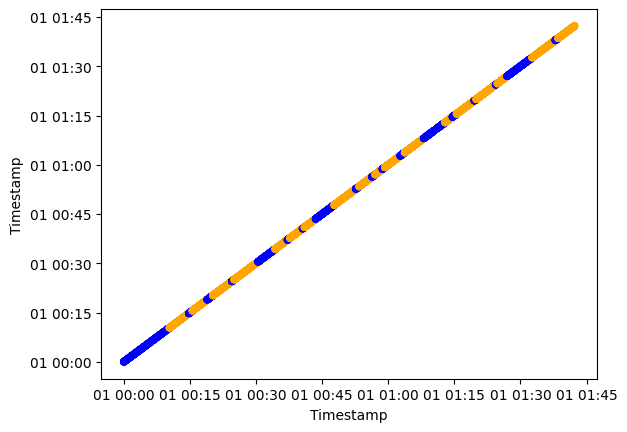

In [113]:
df["Color"] = np.where(df["Label"] == "gameplay", "orange", "blue")

df["Timestamp"] = pd.to_datetime(df["Frame"], unit="s")

df.plot.scatter(x="Timestamp", y="Timestamp", c="Color")

### Handling sets

In [114]:
df["Timestamp"] = pd.to_datetime(df["Frame"], unit="s")

def group_labels(df: pd.DataFrame, col_name: str) -> pd.DataFrame:
    """
    Groups any consecutive timestamp with the same label in a single entry.
    The entry is then filled with "Start Time" and "End Time", each containing
    information about when the label changed. Returns a labeled dataframe.
    """

    # creates an empty segments dataframe
    segments = pd.DataFrame(columns=["Label", "Start Time", "End Time"])

    # initial start time
    start_time = df.iloc[0]["Timestamp"]

    for i in range(df.shape[0]):
        try:
            # slices the df whenever a new label is encountered
            if df.iloc[i][col_name] != df.iloc[i + 1][col_name]:
                duration = df.iloc[i]["Timestamp"] - start_time

                segments = pd.concat(
                    [
                        segments,
                        pd.DataFrame(
                            [
                                {
                                    "Label": df.iloc[i]["Label"],
                                    "Start Time": start_time,
                                    "End Time": df.iloc[i]["Timestamp"],
                                    "Duration": duration,
                                }
                            ],
                        ),
                    ]
                )

                # new start time
                start_time = df.iloc[i]["Timestamp"]

        except IndexError:
            # handles the last entry
            duration = df.iloc[i]["Timestamp"] - start_time

            segments = pd.concat(
                [
                    segments,
                    pd.DataFrame(
                        [
                            {
                                "Label": df.iloc[i]["Label"],
                                "Start Time": start_time,
                                "End Time": df.iloc[i]["Timestamp"],
                                "Duration": duration,
                            }
                        ],
                    ),
                ]
            )

            # new start time
            start_time = df.iloc[i]["Timestamp"]

    return segments

In [196]:
timestamps_df = group_labels(df, "Label")

# create a colur column for visualization purposes
timestamps_df["Color"] = np.where(
    timestamps_df["Label"] == "gameplay", "orange", "blue"
)

timestamps_df.head(10)

,Label,Start Time,End Time,Duration,Color
0,junk,1970-01-01 00:00:00,1970-01-01 00:10:21,0 days 00:10:21,blue
0,gameplay,1970-01-01 00:10:21,1970-01-01 00:14:40,0 days 00:04:19,orange
0,junk,1970-01-01 00:14:40,1970-01-01 00:15:33,0 days 00:00:53,blue
0,gameplay,1970-01-01 00:15:33,1970-01-01 00:18:48,0 days 00:03:15,orange
0,junk,1970-01-01 00:18:48,1970-01-01 00:20:12,0 days 00:01:24,blue
0,gameplay,1970-01-01 00:20:12,1970-01-01 00:24:22,0 days 00:04:10,orange
0,junk,1970-01-01 00:24:22,1970-01-01 00:25:01,0 days 00:00:39,blue
0,gameplay,1970-01-01 00:25:01,1970-01-01 00:30:19,0 days 00:05:18,orange
0,junk,1970-01-01 00:30:19,1970-01-01 00:34:19,0 days 00:04:00,blue
0,gameplay,1970-01-01 00:34:19,1970-01-01 00:37:01,0 days 00:02:42,orange


Text(0.5, 1.0, 'Games (with junk)')

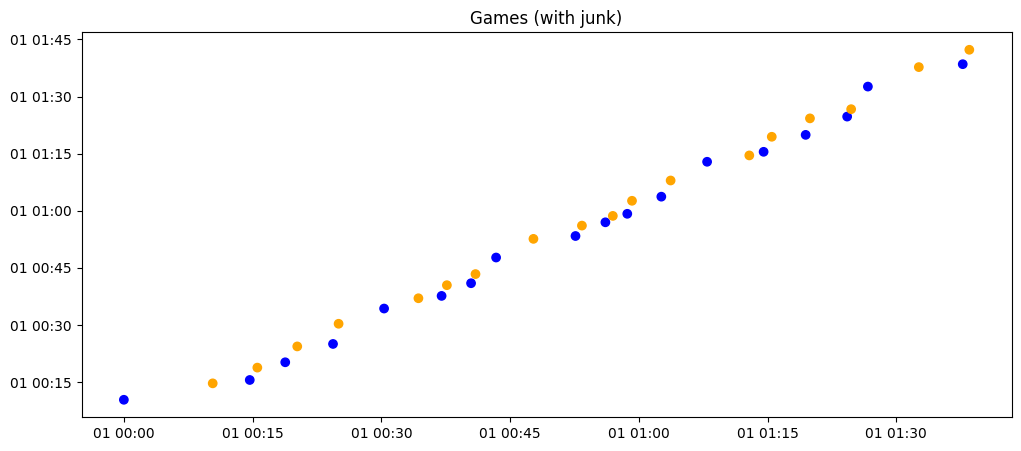

In [215]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(num=None, figsize=(12, 5))

# reminder: blue = junk, orange = gameplay
plt.scatter(
    x=timestamps_df["Start Time"], y=timestamps_df["End Time"], c=timestamps_df["Color"]
)

plt.title("Games (with junk)")

Text(0.5, 1.0, 'Games (excluding junk)')

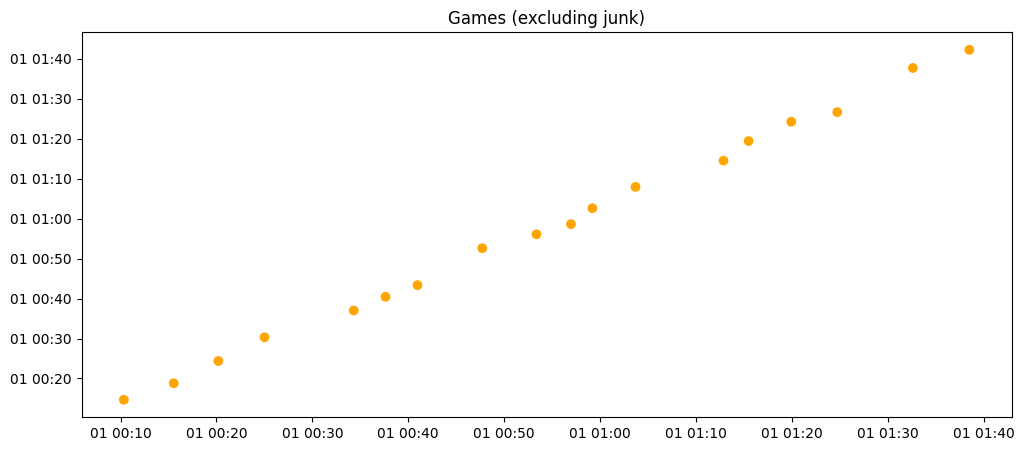

In [216]:
figure(num=None, figsize=(12, 5))

games_df = timestamps_df[timestamps_df["Label"] == "gameplay"]

plt.scatter(x=games_df["Start Time"], y=games_df["End Time"], c=games_df["Color"])
plt.title("Games (excluding junk)")

In [200]:
timestamps_df.to_csv("df_timestamps_grouped.csv", index=False)

## Clustering


In [202]:
timestamps_df = pd.read_csv("df_timestamps_grouped.csv")
timestamps_df.head(10)

,Label,Start Time,End Time,Duration,Color
0,junk,1970-01-01 00:00:00,1970-01-01 00:10:21,0 days 00:10:21,blue
1,gameplay,1970-01-01 00:10:21,1970-01-01 00:14:40,0 days 00:04:19,orange
2,junk,1970-01-01 00:14:40,1970-01-01 00:15:33,0 days 00:00:53,blue
3,gameplay,1970-01-01 00:15:33,1970-01-01 00:18:48,0 days 00:03:15,orange
4,junk,1970-01-01 00:18:48,1970-01-01 00:20:12,0 days 00:01:24,blue
5,gameplay,1970-01-01 00:20:12,1970-01-01 00:24:22,0 days 00:04:10,orange
6,junk,1970-01-01 00:24:22,1970-01-01 00:25:01,0 days 00:00:39,blue
7,gameplay,1970-01-01 00:25:01,1970-01-01 00:30:19,0 days 00:05:18,orange
8,junk,1970-01-01 00:30:19,1970-01-01 00:34:19,0 days 00:04:00,blue
9,gameplay,1970-01-01 00:34:19,1970-01-01 00:37:01,0 days 00:02:42,orange


### Clustering (no filtering)


In [ ]:
n_clusters = 5

In [206]:
from sklearn.cluster import KMeans

# ensure that Start/End Time columns have the correct type
timestamps_df["Start Time"] = pd.to_datetime(timestamps_df["Start Time"])
timestamps_df["End Time"] = pd.to_datetime(timestamps_df["End Time"])

# init KMeans and execute it
kmeans = KMeans(n_clusters=n_clusters, n_init="auto")
labels = kmeans.fit_predict(timestamps_df[["Start Time", "End Time"]])

# add a clusters column
timestamps_df["Cluster"] = labels

timestamps_df.head(10)

,Label,Start Time,End Time,Duration,Color,Cluster
0,junk,1970-01-01 00:00:00,1970-01-01 00:10:21,0 days 00:10:21,blue,2
1,gameplay,1970-01-01 00:10:21,1970-01-01 00:14:40,0 days 00:04:19,orange,2
2,junk,1970-01-01 00:14:40,1970-01-01 00:15:33,0 days 00:00:53,blue,2
3,gameplay,1970-01-01 00:15:33,1970-01-01 00:18:48,0 days 00:03:15,orange,2
4,junk,1970-01-01 00:18:48,1970-01-01 00:20:12,0 days 00:01:24,blue,2
5,gameplay,1970-01-01 00:20:12,1970-01-01 00:24:22,0 days 00:04:10,orange,2
6,junk,1970-01-01 00:24:22,1970-01-01 00:25:01,0 days 00:00:39,blue,2
7,gameplay,1970-01-01 00:25:01,1970-01-01 00:30:19,0 days 00:05:18,orange,2
8,junk,1970-01-01 00:30:19,1970-01-01 00:34:19,0 days 00:04:00,blue,3
9,gameplay,1970-01-01 00:34:19,1970-01-01 00:37:01,0 days 00:02:42,orange,3


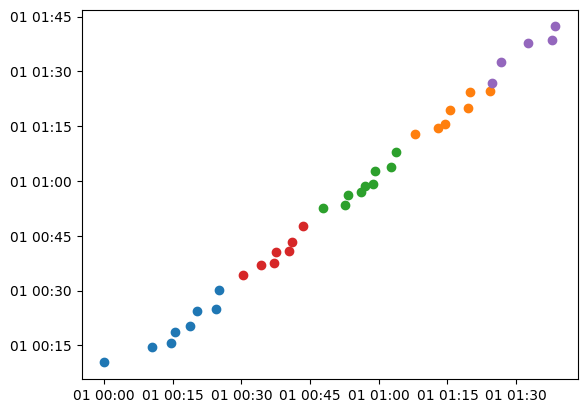

In [204]:
clusters_labels = [timestamps_df[labels == i] for i in range(n_clusters)]

cols = timestamps_df.columns

for i in range(len(clusters_labels)):
    plt.scatter(clusters_labels[i]["Start Time"], clusters_labels[i]["End Time"])

plt.show()

In [208]:
for idx in timestamps_df["Cluster"].unique():
    start_time = timestamps_df[timestamps_df["Cluster"] == idx].iloc[0]["Start Time"]
    end_time = timestamps_df[timestamps_df["Cluster"] == idx].iloc[-1]["End Time"]

    print(f"Set {idx}: {str(start_time)[11:]} - {str(end_time)[11:]}")

Set 2: 00:00:00 - 00:30:19
Set 3: 00:30:19 - 00:47:43
Set 1: 00:47:43 - 01:07:57
Set 0: 01:07:57 - 01:26:41
Set 4: 01:26:41 - 01:42:17


### Clustering (games-only)


In [212]:
from sklearn.cluster import KMeans

n_clusters = 5

games_df["Start Time"] = pd.to_datetime(games_df["Start Time"])
games_df["End Time"] = pd.to_datetime(games_df["End Time"])

kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto")
labels = kmeans.fit_predict(games_df[["Start Time", "End Time"]])

games_df["Cluster"] = labels

games_df.head(10)

,Label,Start Time,End Time,Duration,Color,Cluster
0,gameplay,1970-01-01 00:10:21,1970-01-01 00:14:40,0 days 00:04:19,orange,3
0,gameplay,1970-01-01 00:15:33,1970-01-01 00:18:48,0 days 00:03:15,orange,3
0,gameplay,1970-01-01 00:20:12,1970-01-01 00:24:22,0 days 00:04:10,orange,3
0,gameplay,1970-01-01 00:25:01,1970-01-01 00:30:19,0 days 00:05:18,orange,3
0,gameplay,1970-01-01 00:34:19,1970-01-01 00:37:01,0 days 00:02:42,orange,1
0,gameplay,1970-01-01 00:37:38,1970-01-01 00:40:27,0 days 00:02:49,orange,1
0,gameplay,1970-01-01 00:40:58,1970-01-01 00:43:22,0 days 00:02:24,orange,1
0,gameplay,1970-01-01 00:47:43,1970-01-01 00:52:37,0 days 00:04:54,orange,0
0,gameplay,1970-01-01 00:53:22,1970-01-01 00:56:06,0 days 00:02:44,orange,0
0,gameplay,1970-01-01 00:56:58,1970-01-01 00:58:39,0 days 00:01:41,orange,0


In [213]:
for idx in games_df["Cluster"].unique():
    start_time = games_df[games_df["Cluster"] == idx].iloc[0]["Start Time"]
    end_time = games_df[games_df["Cluster"] == idx].iloc[-1]["End Time"]

    print(f"Set {idx}: {str(start_time)[11:]} - {str(end_time)[11:]}")

Set 3: 00:10:21 - 00:30:19
Set 1: 00:34:19 - 00:43:22
Set 0: 00:47:43 - 01:07:57
Set 2: 01:12:52 - 01:26:41
Set 4: 01:32:37 - 01:42:17


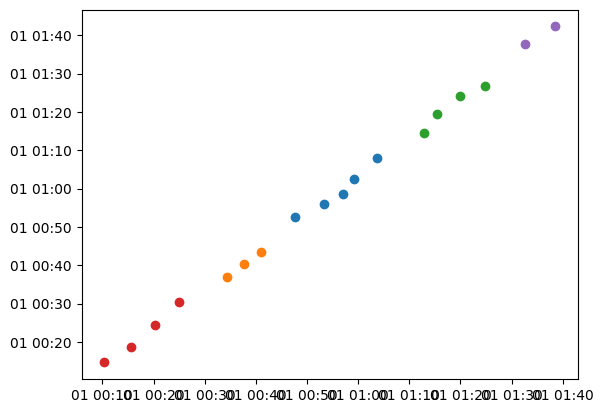

In [214]:
clusters_labels = [games_df[labels == i] for i in range(n_clusters)]

cols = games_df.columns

for i in range(len(clusters_labels)):
    plt.scatter(clusters_labels[i]["Start Time"], clusters_labels[i]["End Time"])

plt.show()